# Muhammad Shamil Umar

In [60]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [33]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\CO2_Readings_Forecasting\SPX.csv")
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0


In [34]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
print(df.shape)
df.head(3)

(23323, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1927-12-30,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23323 entries, 1927-12-30 to 2020-11-04
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       23323 non-null  datetime64[ns]
 1   Open       23323 non-null  float64       
 2   High       23323 non-null  float64       
 3   Low        23323 non-null  float64       
 4   Close      23323 non-null  float64       
 5   Adj Close  23323 non-null  float64       
 6   Volume     23323 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


We will be working on forcasting closing price of S&P stocks

Text(0.5, 1.0, 'Daily Closing against time')

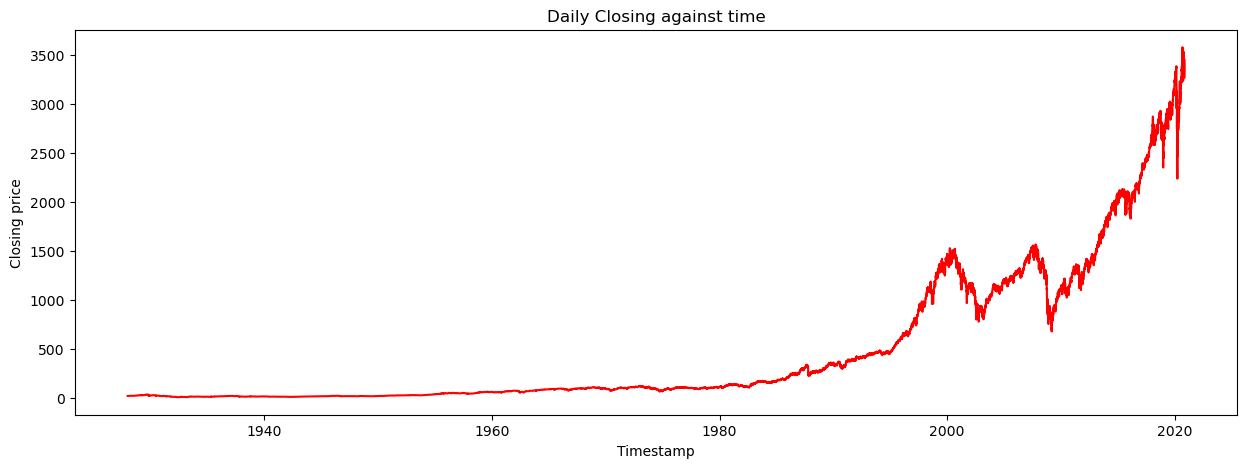

In [36]:
fig = plt.figure(figsize=(15, 5))
plt.plot(df.index,df['Close'],color='red')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.title('Daily Closing against time')

In [37]:
monthly = df.resample('M').mean()

In [38]:
monthly = monthly.drop(['Date'],axis=1)
monthly.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-31,17.660000,17.660000,17.660000,17.660000,17.660000,0.0
1928-01-31,17.520000,17.520000,17.520000,17.520000,17.520000,0.0
1928-02-29,17.324211,17.324211,17.324211,17.324211,17.324211,0.0
1928-03-31,18.233182,18.233182,18.233182,18.233182,18.233182,0.0
1928-04-30,19.371000,19.371000,19.371000,19.371000,19.371000,0.0


Text(0.5, 1.0, 'Monthly Closing against time')

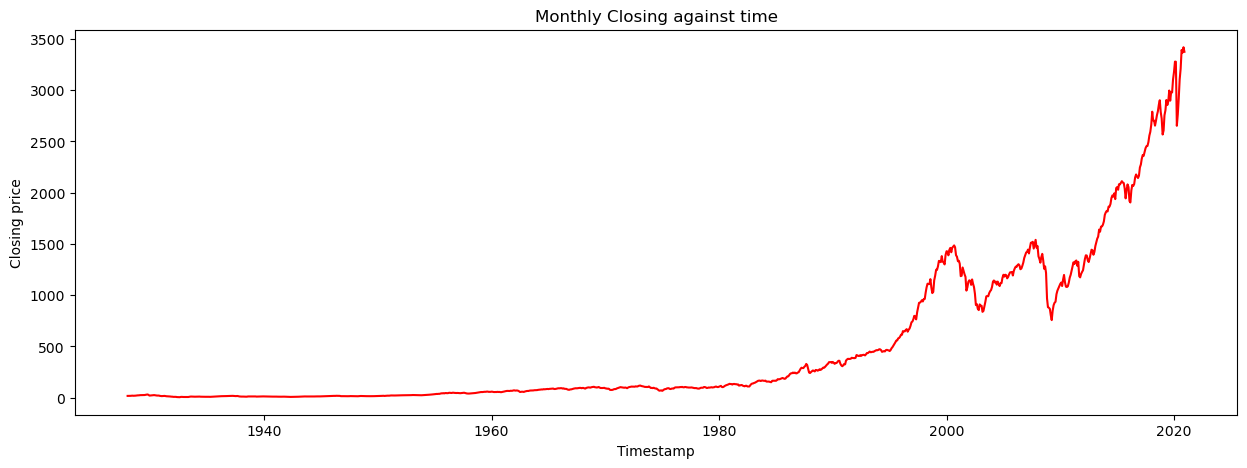

In [26]:
fig = plt.figure(figsize=(15, 5))
plt.plot(monthly.index,monthly['Close'],color='red')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.title('Monthly Closing against time')

In [42]:
def adfuller_test(sales):
    result=adfuller(sales,autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [43]:
adfuller_test(monthly['Close'])

ADF Test Statistic : 3.830169047833065
p-value : 1.0
#Lags Used : 22
Number of Observations Used : 1093
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [44]:
monthly['First_Diff']=monthly['Close']-monthly['Close'].shift(1)
monthly = monthly.dropna()


In [45]:
monthly.head(5)

,Open,High,Low,Close,Adj Close,Volume,First_Diff
Date,,,,,,,
1928-01-31,17.520000,17.520000,17.520000,17.520000,17.520000,0.0,-0.140000
1928-02-29,17.324211,17.324211,17.324211,17.324211,17.324211,0.0,-0.195789
1928-03-31,18.233182,18.233182,18.233182,18.233182,18.233182,0.0,0.908971
1928-04-30,19.371000,19.371000,19.371000,19.371000,19.371000,0.0,1.137818
1928-05-31,20.004091,20.004091,20.004091,20.004091,20.004091,0.0,0.633091


In [46]:
adfuller_test(monthly['First_Diff'])

ADF Test Statistic : -5.356478035551501
p-value : 4.178121517774321e-06
#Lags Used : 22
Number of Observations Used : 1092
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Text(0.5, 1.0, 'First Difference against time')

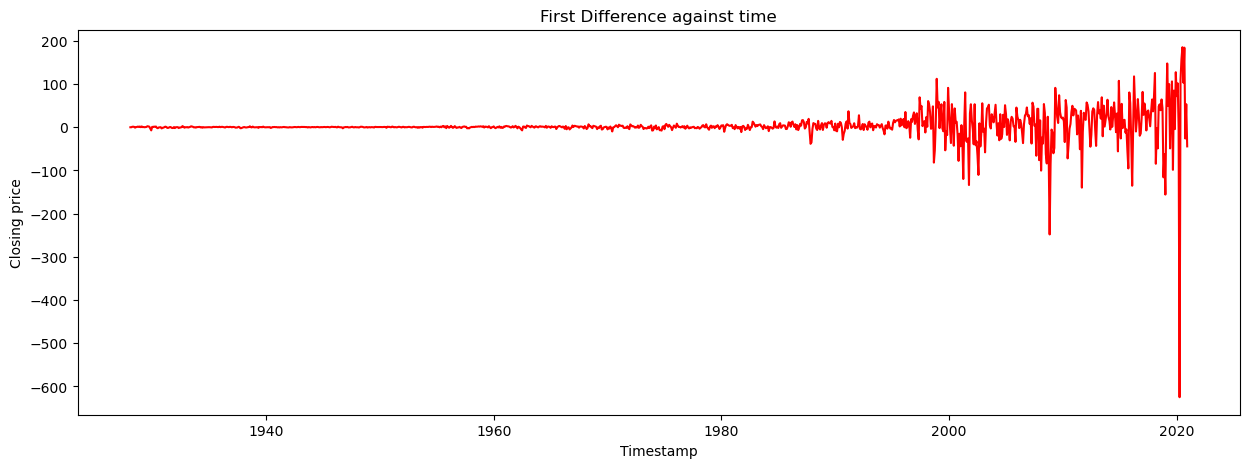

In [47]:
fig = plt.figure(figsize=(15, 5))
plt.plot(monthly.index,monthly['First_Diff'],color='red')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.title('First Difference against time')

# Parameter Selection for ARIMA

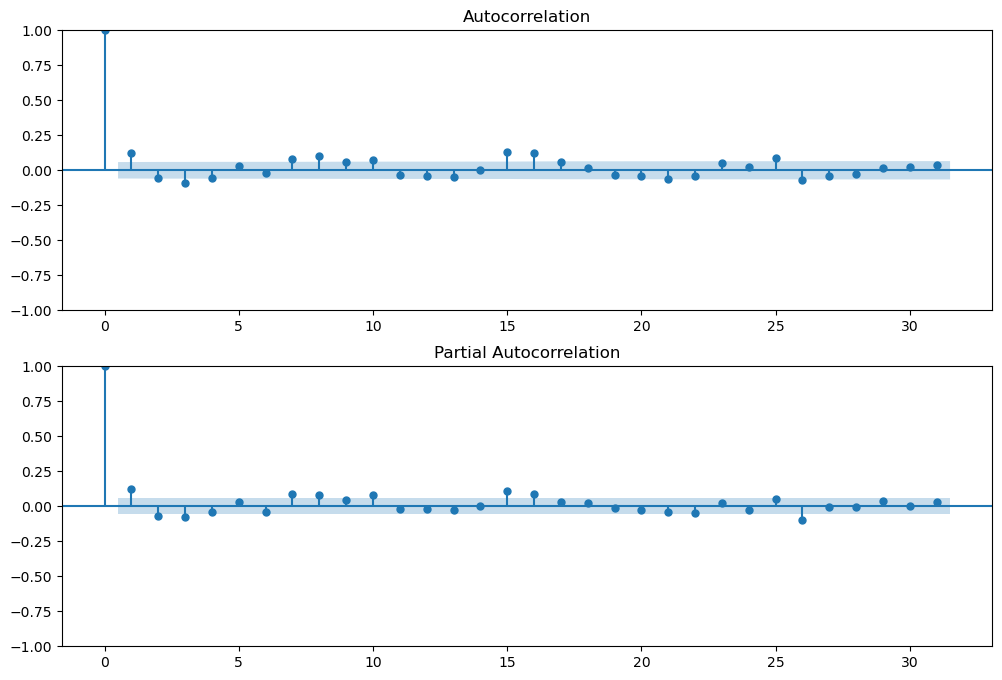

In [56]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly['First_Diff'],ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly['First_Diff'],ax=ax2)

In [183]:
train = monthly[:815]#[monthly.index < "1990"]
test = monthly[815:]#[monthly.index >= "1990"]

In [184]:
from pmdarima import auto_arima
model = auto_arima(train['Close'], seasonal=False, suppress_warnings=True)
print(f"Best p, d, q values: {model.order}")

Best p, d, q values: (0, 2, 3)


In [185]:
series = train['Close']
model = ARIMA(series, order=(0,2,3))
model_fit = model.fit()

In [186]:
start=len(train)
end=len(train)+len(test)-1
forecast = model_fit.predict(start=start,end=end)

Text(0.5, 1.0, 'ARIMA Model')

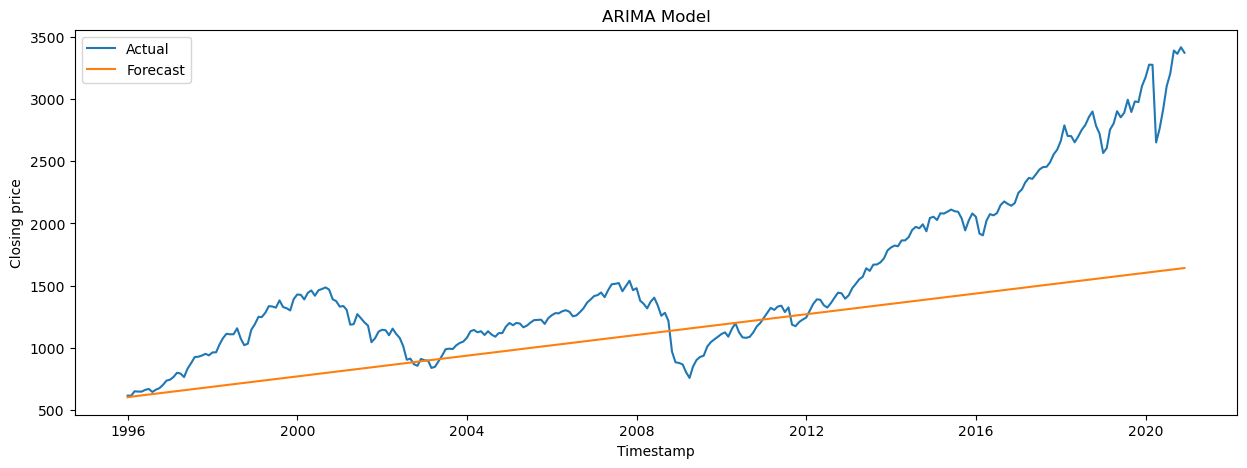

In [216]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,forecast,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('ARIMA Model')

In [188]:
print(f"Train Length = {len(train)}")
print(f"Test Length = {len(test)}")

Train Length = 815
Test Length = 300


In [191]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['Close'], forecast)**(1/2)

604.5282190689031

In [228]:
s_model=sm.tsa.statespace.SARIMAX(train['Close'],order=(0, 2, 3),seasonal_order=(0,2,3,7))
results=s_model.fit()

C:\Users\shami\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [229]:
start=len(train)
end=len(train)+len(test)-1
s_forecast = results.predict(start=start,end=end)

Text(0.5, 1.0, 'SARIMA Model')

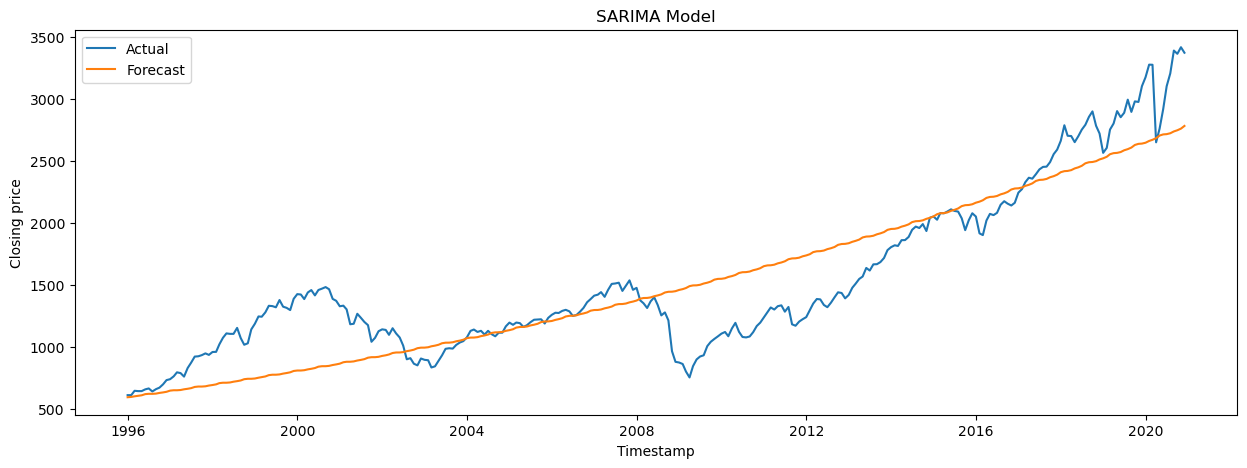

In [230]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,s_forecast,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('SARIMA Model')

In [227]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['Close'], s_forecast)**(1/2)

385.7528877703997

# Saving Arima and Sarima models

In [220]:
import pickle
with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\CO2_Readings_Forecasting\arima.pkl", 'wb') as f:
    pickle.dump(model_fit, f)

with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\CO2_Readings_Forecasting\sarima.pkl", 'wb') as f:
    pickle.dump(results, f)